# Determine N<sub>2</sub>O Flux from Sorghum Cropping Systems in the Great Plains - Kathy Gehl

## I. Motivation

* **Project background**

    - Study sites have been established in Colby, KS and Goodwell, OK to quantify N<sub>2</sub>O emissions from fields/plots planted to grain sorghum. This project generates a large amount of N<sub>2</sub>O gas measurements over the growing season.
    - Each sampling event is sampled over a time sequence of 0, 15, 30, and 45 minutes. Measured N<sub>2</sub>O concentrations are linearly regressed against the time sequence and the slope is considered the N<sub>2</sub>O flux for that plot on each sampling date. Linear extrapolation is used to estimate flux between sampling points and then season-long emissions are estimated.
    - We currently have been performing these calculations in Excel, but having a code in place would streamline the process and would help reduce human errors.
    

* **Objectives**

    - Import raw .csv output files from gas chromotograph
    - Calculate daily N<sub>2</sub>O flux for each plot at each sampling event
        * Flux will be calculated using linear regression
    - Intended users of this code will be those associated with this project and others that seek to analyze gas measurement data from a gas chromatograph with an output similar to this one.

## II. Import Modules

In [1]:
import pandas as pd   #Pandas is used for its capability of manipulating data
import glob           #Glob is used for navigating to the correct file location/directory
import numpy as np    #Numpy is another good package for data science. Creates arrays and allows for manipulation.
import matplotlib.pyplot as plt   #This is used for creating plots/graphs
%matplotlib inline

from scipy import stats   #This package contains many statistical functions, including linear regression which is needed for this project.

## III. Directory and file set-up

In [2]:
#Set variables for the dataset directory, datafile, filename to use for results output file

dataset_dir = '/Users/kgehl/Desktop/Coding/Project/Datasets'
datafile = 'Sample_data_set2.csv'   #User will input the name of the data file they want to import
filename = datafile.split('.')[0]   #This creates a filename without the .csv ending that will be used to create the results output .csv file.
glob.os.chdir(dataset_dir)          #This navigates to the correct folder with the date file

## IV. Read and View Data File

In [3]:
# Reading the datafile and creating the dataframe

N2O = pd.read_csv('Sample_data_set2.csv', sep=',')   #Creates the initial Data frame of N2O
N2O.head(10)  #View first 10 rows of raw data file

,Unnamed: 0,Area/N2O,Quantity/N2O
0,2018\06\STD CHK 262218.DATA,8615.6,2.42
1,2018\06\COLBY_304_T4562218.DATA,1750.1,0.49
2,2018\06\COLBY_304_T3062218.DATA,1771.6,0.50
3,2018\06\COLBY_304_T1562218.DATA,1774.6,0.50
4,2018\06\COLBY_304_T062218.DATA,1750.6,0.49
5,2018\06\COLBY_303_T4562218.DATA,5081.6,1.43
6,2018\06\COLBY_303_T3062218.DATA,4473.5,1.26
7,2018\06\COLBY_303_T1562218.DATA,3076.3,0.87
8,2018\06\COLBY_303_T062218.DATA,1803.3,0.51
9,2018\06\COLBY_302B_T4562218.DATA,2209.6,0.62


## V. Dataframe Manipulation
   - Removes a column of data that is not needed
   - Removes all variations of "check" samples
   - Cleans up the data frame (splits, renames, and reorders columns)

In [4]:
#Renaming/cleaning up some of the raw columns

N2O = N2O.drop(columns=['Area/N2O'])      #Drops an column of data not needed.
N2O = N2O.rename(columns={'Unnamed: 0':'Sample_ID', 'Quantity/N2O':'N2O'})  #Renamed some column headings.
N2O.head(5)

,Sample_ID,N2O
0,2018\06\STD CHK 262218.DATA,2.42
1,2018\06\COLBY_304_T4562218.DATA,0.49
2,2018\06\COLBY_304_T3062218.DATA,0.50
3,2018\06\COLBY_304_T1562218.DATA,0.50
4,2018\06\COLBY_304_T062218.DATA,0.49


In [5]:
#Deleting rows that are the standard and air checks. The labels are not consistent so I had to put in several options for the removal to work.

Chk_rows = ['CHK', 'Check', 'CHECK']
pattern = '|'.join(Chk_rows)
N2O_nochecks = N2O.loc[~N2O['Sample_ID'].str.contains(pattern, case=False)]  #New df is called N2O_nochecks. This is temporary.
N2O_nochecks.head(5)

,Sample_ID,N2O
1,2018\06\COLBY_304_T4562218.DATA,0.49
2,2018\06\COLBY_304_T3062218.DATA,0.50
3,2018\06\COLBY_304_T1562218.DATA,0.50
4,2018\06\COLBY_304_T062218.DATA,0.49
5,2018\06\COLBY_303_T4562218.DATA,1.43


In [6]:
#Splitting Sample_ID column into Site, Plot, Time

N2O_split = N2O_nochecks.join(N2O_nochecks.Sample_ID.str.split("_", expand=True).rename(columns={0:'Site', 1:'Plot', 2:'Time'}))  
N2O_split.head(5)   #N2O_split is the final name of the df. It will remain this name throughout the rest of the code.

,Sample_ID,N2O,Site,Plot,Time
1,2018\06\COLBY_304_T4562218.DATA,0.49,2018\06\COLBY,304,T4562218.DATA
2,2018\06\COLBY_304_T3062218.DATA,0.50,2018\06\COLBY,304,T3062218.DATA
3,2018\06\COLBY_304_T1562218.DATA,0.50,2018\06\COLBY,304,T1562218.DATA
4,2018\06\COLBY_304_T062218.DATA,0.49,2018\06\COLBY,304,T062218.DATA
5,2018\06\COLBY_303_T4562218.DATA,1.43,2018\06\COLBY,303,T4562218.DATA


In [7]:
#Splitting the 'new' Site column by '\' into 3 columns: Year, Month, and Location

N2O_split = N2O_split.join(N2O_split.Site.str.split("\\", expand=True))
N2O_split.columns = ['Sample_ID', 'N2O', 'Site', 'Plot', 'Time', 'Year', 'Month', 'Location']

#Dropping the Site column as its redundant now

N2O_split = N2O_split.drop(columns=['Site'])

#Changing the order of the columns

N2O_split = N2O_split[['Sample_ID', 'Year', 'Month', 'Location', 'Plot', 'Time', 'N2O']]  
N2O_split.head(10)   #View the final version of the N2O_split df.


,Sample_ID,Year,Month,Location,Plot,Time,N2O
1,2018\06\COLBY_304_T4562218.DATA,2018,06,COLBY,304,T4562218.DATA,0.49
2,2018\06\COLBY_304_T3062218.DATA,2018,06,COLBY,304,T3062218.DATA,0.50
3,2018\06\COLBY_304_T1562218.DATA,2018,06,COLBY,304,T1562218.DATA,0.50
4,2018\06\COLBY_304_T062218.DATA,2018,06,COLBY,304,T062218.DATA,0.49
5,2018\06\COLBY_303_T4562218.DATA,2018,06,COLBY,303,T4562218.DATA,1.43
6,2018\06\COLBY_303_T3062218.DATA,2018,06,COLBY,303,T3062218.DATA,1.26
7,2018\06\COLBY_303_T1562218.DATA,2018,06,COLBY,303,T1562218.DATA,0.87
8,2018\06\COLBY_303_T062218.DATA,2018,06,COLBY,303,T062218.DATA,0.51
9,2018\06\COLBY_302B_T4562218.DATA,2018,06,COLBY,302B,T4562218.DATA,0.62
10,2018\06\COLBY_302B_T3062218.DATA,2018,06,COLBY,302B,T3062218.DATA,0.58


## VI. Linear Regression Testing
   - Setting up the x,y variables for one plot
   - Testing the linregress function

In [8]:
# Establishing x and y variables for one plot (303)

x_values = np.array([45, 30, 15, 0])  #Time series in minutes descending in order the gas samples were processed on the gas chromatograph
y_values = N2O_split.N2O[4:8]

# Validating the correct N2O data was accessed

y_values  #These values are the correct ones from the df


5    1.43
6    1.26
7    0.87
8    0.51
Name: N2O, dtype: float64

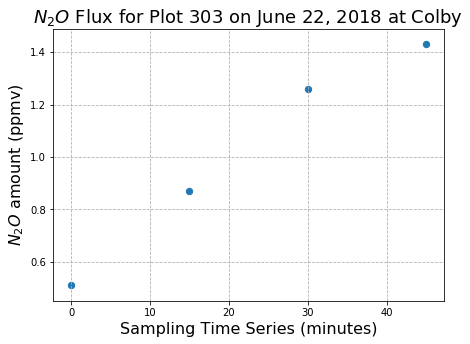

In [9]:
# Creating sample scatter plot to test the dataframe using one plot (303)

plt.figure(figsize=(7,5))

plt.scatter(x_values, y_values, s=40, marker='o')
plt.rcParams['axes.grid'] = True
plt.grid(linestyle='--')
plt.rcParams['ytick.labelsize'] = 14.0
plt.rcParams['xtick.labelsize'] = 14.0
plt.title('$N_2O$ Flux for Plot 303 on June 22, 2018 at Colby', fontsize=18)
plt.xlabel('Sampling Time Series (minutes)', fontsize=16)
plt.ylabel('$N_2O$ amount (ppmv)', fontsize=16)
plt.show()


In [10]:
# Testing the linregress method with data from one plot (303)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)

print('Slope:', slope)  # This value matches the slope calculated in Excel
print('Intercept:',intercept)
print('r:',r_value)
print('r-squared:',r_value**2)
print('p-value:', p_value)
print('Std error:', std_err)

Slope: 0.021
Intercept: 0.545
r: 0.9879755146408643
r-squared: 0.9760956175298807
p-value: 0.012024485359135695
Std error: 0.002323790007724438


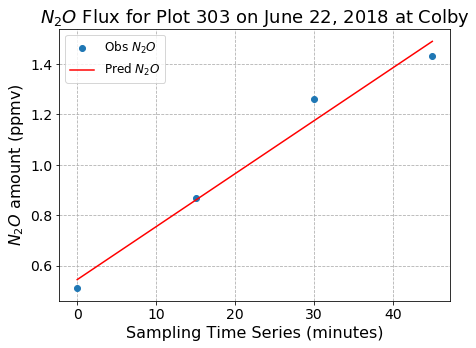

In [11]:
# Creating the plot of the observed N2O with the regression line

y_pred = intercept + slope*x_values

plt.figure(figsize=(7,5))
plt.plot(x_values, y_values,'o', label= 'Obs $N_2O$')
plt.plot(x_values, y_pred,'-r', label= 'Pred $N_2O$')
plt.grid(linestyle='--')
plt.rcParams['grid.color'] = 'k'
plt.rcParams['ytick.labelsize'] = 14.0
plt.rcParams['xtick.labelsize'] = 14.0
plt.legend(fontsize=12)
plt.title('$N_2O$ Flux for Plot 303 on June 22, 2018 at Colby', fontsize=18)
plt.xlabel('Sampling Time Series (minutes)', fontsize=16)
plt.ylabel('$N_2O$ amount (ppmv)', fontsize=16)
plt.show()

## VII. Creating Final Code

   - The next step is creating the code that will run the regression analysis for each plot in the entire dataset.
   - This code will not create regression plots for each "Plot". It will compile all the linregress outputs in a results datafile, sorted by "Plot".
   - With the code outlined above, the regression plot for an individual plot can be created if needed by the user.

In [12]:
# This is setting up the x and y data for the regression analysis.

N2O_split = N2O_split.reset_index(drop = True)  # This resets the df index after making several changes in the above code.

y_data = []   # y data will fill from the N2O column
x_data = np.array([45, 30, 15, 0])  # x data is the time series in minutes. The order is descending to match the datafile.

In [13]:
# Each plot is anaylzed across the time series (4 points). This makes the code run the anaylsis for each plot.

Plot_List = list(N2O_split.Plot)
Plot_List = list(dict.fromkeys(Plot_List))

In [14]:
# Create the results df with the sorted by Plot and columns added for each output

results = pd.DataFrame(Plot_List)
results.columns = ['Plot']
results.insert(1, 'N2O_Slope', '')
results.insert(2, 'intercept', '')
results.insert(3, 'r_value', '')
results.insert(4, 'p_value', '')
results.insert(5, 'std_err', '')


In [15]:
# Calculate slope and other outputs using linregress iterated over each plot for the given time sequence

count = 0

for x in Plot_List:
    for y in range(0, len(N2O_split.Plot)):
        if N2O_split.Plot[y] == x:
            y_data.append(N2O_split.N2O[y])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    results.N2O_Slope[count] = slope
    results.intercept[count] = intercept
    results.r_value[count] = r_value
    results.p_value[count] = p_value
    results.std_err[count] = std_err
    count += 1
    y_data = []

results

,Plot,N2O_Slope,intercept,r_value,p_value,std_err
0,304,0,0.495,0,1,0.000210819
1,303,0.021,0.545,0.987976,0.0120245,0.00232379
2,302B,0.00266667,0.5,1,1.11032e-16,2.80979e-11
3,302,0.0404667,0.517,0.99907,0.000929631,0.00123468
4,301,0.0428,0.592,0.990698,0.00930173,0.00415692
5,204,0.0006,0.489,0.923381,0.0766195,0.000176383
6,203B,0.0024,0.501,0.99846,0.00153965,9.42809e-05
7,203,0.016,0.485,0.996374,0.00362602,0.000966092
8,202,0.00873333,0.506,0.99843,0.00156963,0.00034641
9,201,0.0199333,0.549,0.983984,0.0160161,0.00255343


## VIII. Finalizing the Output File

In [16]:
# Sorting the results dataframe by Plot in ascending order

results = results.sort_values('Plot')
results.head(5)   #Checking the sort is correct

,Plot,N2O_Slope,intercept,r_value,p_value,std_err
14,101,0.00646667,0.542,0.941481,0.0585186,0.00163707
13,101B,0.00173333,0.506,0.982708,0.0172924,0.00023094
12,102,0.0370667,0.526,0.998734,0.00126564,0.00131993
11,103,0.00766667,0.54,0.948665,0.0513346,0.00180739
10,104,0.0072,0.503,0.99846,0.00153965,0.000282843


In [17]:
# Saving the output as a .csv in the correct directory with the original file name and adding results at the end

results.to_csv(dataset_dir + filename + '_' + 'results.csv')

In [18]:
 # Checking the final output results file

pd.read_csv('Sample_data_set2_results.csv').head(5)

,Unnamed: 0,Plot,N2O_Slope,intercept,r_value,p_value,std_err
0,14,101,0.006467,0.542,0.941481,0.058519,0.001637
1,13,101B,0.001733,0.506,0.982708,0.017292,0.000231
2,12,102,0.037067,0.526,0.998734,0.001266,0.001320
3,11,103,0.007667,0.540,0.948665,0.051335,0.001807
4,10,104,0.007200,0.503,0.998460,0.001540,0.000283


## IX. Wrap-up

### Challenges encountered during this project

- The sample ID in the raw datafile from the gas chromotograph output was very challenging to work with.
    - **2018\06\COLBY_304_T4562218.DATA**
    - The last part of the ID has no separators between the time (T45), the month (6), the day (22), and the year (18). Also, T0 should have been listed T00, as the other times   were double digits. 
- Removing the check samples from the dataset was also not as easy as it could have been. In one data file, "check" was written 3 different ways. Other users of this code may need to revise for their dataset "check" names.
- Figuring out a way to remove all three different variations in only a couple lines of code was one of my highpoints (see cell 11 above)! 

### Future plans to expand this program

- With the daily flux calculated for each plot, I can continue to expand this code to calculate the cumulative growing season flux for each plot
- Cumulative flux values for each plot can then be used to get an average for the season by treatment
- Yield data can be imported to calculate yield-scaled N2O emissions
- Figures, such as graphs, can be generated from the cumulative results for each growing season and used to compare across treatments and years.